# 1. Install Dependencies and Setup

In [ ]:
!pip install tensorflow opencv-python matplotlib

In [ ]:
!pip list

In [1]:
import tensorflow as tf
import os

In [2]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

# 2. Remove dodgy images

In [ ]:
import os
from PIL import Image

data_dir = 'data'

for image_class in os.listdir(data_dir):
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            if image.endswith('.jpg'):
            
                img = Image.open(image_path)
                
            
                new_image_path = os.path.splitext(image_path)[0] + '.jpeg'
                
               
                img.save(new_image_path, 'JPEG')
                
                print('Converted file: {} to {}'.format(image_path, new_image_path))
                
             
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))

In [4]:
import cv2
import imghdr

In [5]:
data_dir = 'data' 

In [6]:
image_exts = ['jpeg','JPG', 'bmp', 'png']

In [7]:
for image_class in os.listdir(data_dir): 
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try: 
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts: 
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e: 
            print('Issue with image {}'.format(image_path))
            # os.remove(image_path)

# 3. Load Data

In [8]:
import numpy as np
from matplotlib import pyplot as plt

In [9]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 4999 files belonging to 1 classes.


In [10]:
data_iterator = data.as_numpy_iterator()

In [11]:
batch = data_iterator.next()

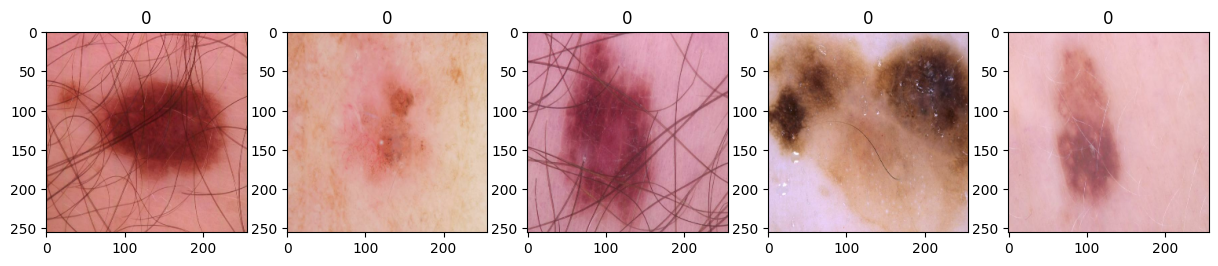

In [12]:
fig, ax = plt.subplots(ncols=5, figsize=(15,15))
for idx, img in enumerate(batch[0][:5]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# 4. Scale Data

In [13]:
data = data.map(lambda x,y: (x/255, y))

In [14]:
data.as_numpy_iterator().next()

(array([[[[0.33393076, 0.23981312, 0.3025582 ],
          [0.3678615 , 0.27374387, 0.33648896],
          [0.39684436, 0.30272672, 0.3654718 ],
          ...,
          [0.09270833, 0.06133578, 0.05349265],
          [0.09797794, 0.06660539, 0.05876226],
          [0.10196079, 0.07058824, 0.0627451 ]],
 
         [[0.3579963 , 0.26387867, 0.32662377],
          [0.38497242, 0.29085478, 0.35359988],
          [0.40598074, 0.3118631 , 0.3746082 ],
          ...,
          [0.09411765, 0.0627451 , 0.05490196],
          [0.09797794, 0.06660539, 0.05876226],
          [0.09803922, 0.06666667, 0.05882353]],
 
         [[0.36827514, 0.27415746, 0.33690256],
          [0.39186582, 0.29774815, 0.36049327],
          [0.41165748, 0.31753984, 0.38028494],
          ...,
          [0.09762561, 0.0627451 , 0.06542586],
          [0.0945796 , 0.05969908, 0.06237984],
          [0.09453125, 0.05965073, 0.06233149]],
 
         ...,
 
         [[0.07801777, 0.04272365, 0.05448836],
          [0.07807

# 5. Split Data

In [15]:
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

In [16]:
train_size

109

In [18]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# 6. Build Deep Learning Model

In [19]:
train

<_TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout

In [21]:
model = Sequential()

In [22]:
model.add(Conv2D(16, (3,3), 1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3,3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [23]:
model.compile('adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 30, 30, 16)        0

# 7. Train

In [25]:
logdir='logs'

In [26]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [27]:
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/20
109/109 [==============================] - 77s 687ms/step - loss: 0.0081 - accuracy: 0.9908 - val_loss: 1.0332e-23 - val_accuracy: 1.0000
Epoch 2/20
109/109 [==============================] - 77s 701ms/step - loss: 4.2945e-16 - accuracy: 1.0000 - val_loss: 5.7790e-20 - val_accuracy: 1.0000
Epoch 3/20
109/109 [==============================] - 78s 714ms/step - loss: 4.2904e-16 - accuracy: 1.0000 - val_loss: 5.7797e-20 - val_accuracy: 1.0000
Epoch 4/20
109/109 [==============================] - 80s 730ms/step - loss: 4.2904e-16 - accuracy: 1.0000 - val_loss: 5.7803e-20 - val_accuracy: 1.0000
Epoch 5/20
109/109 [==============================] - 78s 710ms/step - loss: 4.2904e-16 - accuracy: 1.0000 - val_loss: 1.2641e-23 - val_accuracy: 1.0000
Epoch 6/20
109/109 [==============================] - 80s 735ms/step - loss: 4.2904e-16 - accuracy: 1.0000 - val_loss: 5.7798e-20 - val_accuracy: 1.0000
Epoch 7/20
109/109 [==============================] - 92s 843ms/step - loss: 4.2904e-1

# 8. Plot Performance

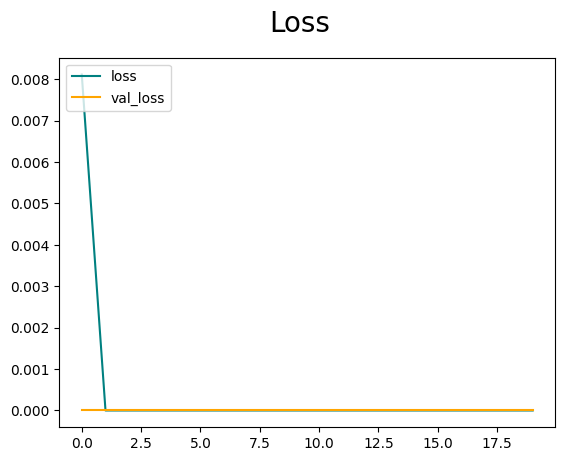

In [28]:
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

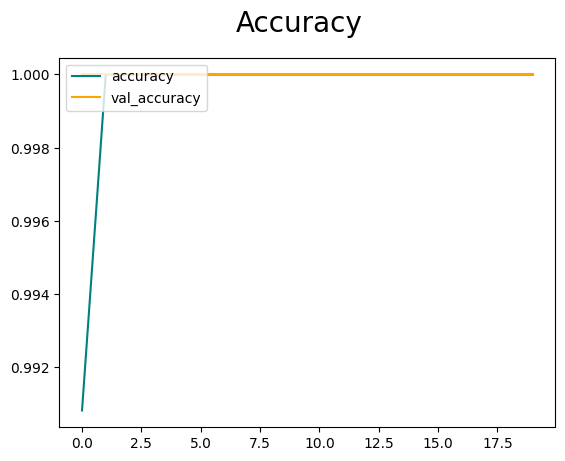

In [29]:
fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# 9. Evaluate

In [30]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

In [31]:
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [32]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 174ms/step


In [33]:
print(pre.result(), re.result(), acc.result())

tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(0.0, shape=(), dtype=float32) tf.Tensor(1.0, shape=(), dtype=float32)


# 10. Test

In [34]:
import cv2

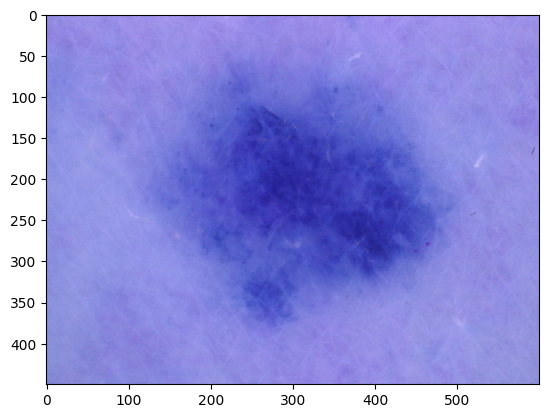

In [45]:
img = cv2.imread('ISIC_0029307.jpg')
plt.imshow(img)
plt.show()

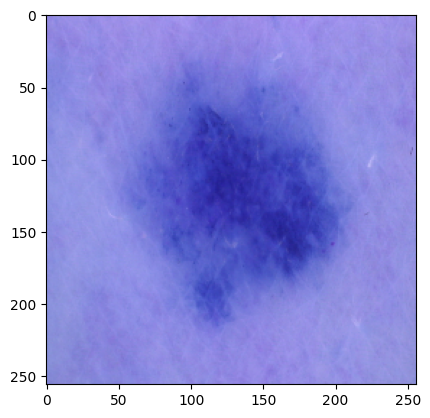

In [46]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [47]:
yhat = model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 0s 36ms/step


In [48]:
yhat

array([[8.297561e-25]], dtype=float32)

In [49]:
if yhat > 0.5: 
    print(f'Predicted class is Sad')
else:
    print(f'Predicted class is Happy')

Predicted class is Sad


# 11. Save the Model

In [ ]:
from tensorflow.keras.models import load_model

In [ ]:
model.save(os.path.join('models','imageclassifier.h5'))

In [ ]:
new_model = load_model('imageclassifier.h5')

In [ ]:
new_model.predict(np.expand_dims(resize/255, 0))